In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from random import randint
import datetime
import bisect
import random
import collections

In [49]:
#########################################################
# Picking a sample from a created CDF
#########################################################

def get_cdf(weights):
    total = sum(weights)
    result = []
    cumsum = 0
    for w in weights:
        cumsum += w
        result.append(cumsum / total)
    return result

def pick_a_sample(population, weights):
    assert len(population) == len(weights)
    cdf_vals = get_cdf(weights)
    x = random.random()
    idx = bisect.bisect(cdf_vals, x)
    return population[idx]

#########################################################
# Markov Chain Grid
#########################################################

def get_markov_chain_grid(compressed_grid, patterns_list):

    patterns = []
    counts = []
    for from_event in patterns_list:

        for to_event in patterns_list:
            pattern = from_event + ',' + to_event
            ids_matches = compressed_grid[compressed_grid['Event_Pattern'].str.contains(pattern)]
            found = 0
            if len(ids_matches) > 0:
                Event_Pattern = '---'.join(ids_matches['Event_Pattern'].values)
                found = Event_Pattern.count(pattern)
            patterns.append(pattern)
            counts.append(found)

    grid_Df = pd.DataFrame({'pairs':patterns, 'counts': counts})

    grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
    grid_Df.head()

    grid_Df = grid_Df.pivot(index='x', columns='y', values='counts', )

    grid_Df.columns= [col for col in grid_Df.columns]
    grid_Df.index.name = None

    grid_Df.fillna(0, inplace=True)
    grid_Df.head()

    grid_Df = grid_Df / grid_Df.sum(1)
    return (grid_Df)

#########################################################
# Markov Chain
#########################################################

def generate_markov_chain(initial_pattern, chain_length, markov_grid_positive, markov_grid_negative):
    actual = []
    predicted = []

    pos = []
    neg = []
    log_odds = []
    predicted_patterns = []
    predicted_patterns.append(initial_pattern)

    for ii in range(0, chain_length -1):
        predicted_patterns.append(pick_a_sample(markov_grid_positive[initial_pattern].index, 
                                                markov_grid_positive[initial_pattern].values))

        if ((predicted_patterns[ii] in list(markov_grid_positive) 
                 and predicted_patterns[ii + 1] in list(markov_grid_positive) 
                 and predicted_patterns[ii] in list(markov_grid_negative) 
                 and predicted_patterns[ii + 1] in list(markov_grid_negative))):

            numerator = markov_grid_positive[predicted_patterns[ii]][predicted_patterns[ii+1]]
            denominator = markov_grid_negative[predicted_patterns[ii]][predicted_patterns[ii+1]]
            if (numerator == 0 and denominator == 0):
                log_value = 0
            elif (denominator == 0):
                log_value = np.log(numerator / 0.00001)
            elif (numerator == 0):
                log_value = np.log(0.00001 / denominator)
            else:
                log_value = np.log(numerator/denominator)
        else:
            log_value = 0

        log_odds.append(log_value)

        pos.append(numerator)
        neg.append(denominator)

    predicted = [1 if p > 0 else 0 for p in log_odds]
    return predicted

#########################################################
# Monte Carlo
#########################################################

def Monte_Carlo(start_point, initial_pattern, vector_length, 
                n_samples, mean, stdev, markov_grid_positive, markov_grid_negative):
    
    samples = np.zeros((vector_length -1, n_samples), dtype = float)
    
    for ii in range(n_samples):
        
        prediction_sample = generate_markov_chain(initial_pattern = initial_pattern,
                                          chain_length = vector_length,
                                          markov_grid_positive = markov_grid_positive,
                                          markov_grid_negative = markov_grid_negative)
        
        actual_value = start_point
        
        sample_n = []
        
        for jj in prediction_sample:
            if jj == 1:
                random_step = -1
                while random_step < 0:
                    random_step = np.random.normal(loc = mean,
                                                   scale = stdev)
            else:
                random_step = 1
                while random_step > 0:
                    random_step = np.random.normal(loc = mean,
                                                   scale = stdev)
            actual_value += random_step
            sample_n.append(actual_value)
            
        samples[:, ii] = sample_n
        
    return samples

#########################################################
# Markov Chain Monte Carlo
#########################################################

def get_stock_price_prediction(ticker, start_date, days_to_evaluate, MCMC_sample_size):
    
    #########################################################
    # Stock Data Acquisition
    #########################################################
    
    historical_data = pd.DataFrame()
    historical_data = wb.DataReader(ticker, data_source = 'yahoo', start = start_date)
    
    #########################################################
    # Defining random sets of rows for training
    #########################################################

    random_sequential = []
    for row_set in range(0, 100000):
        row_quant = randint(10, 30)
        row_start = randint(0, len(historical_data)-row_quant)
        historical_data_subset = historical_data.iloc[row_start : row_start + row_quant]

        Close_Date = max(historical_data_subset.index)
        Close_Gap = historical_data_subset['Close'].pct_change()
        High_Gap = historical_data_subset['High'].pct_change()
        Low_Gap = historical_data_subset['Low'].pct_change() 
        Volume_Gap = historical_data_subset['Volume'].pct_change() 
        Daily_Change = (historical_data_subset['Close'] - historical_data_subset['Open']) / historical_data_subset['Open']
        Outcome_Next_Day_Direction = (historical_data_subset['Volume'].shift(-1) - historical_data_subset['Volume'])
        Daily_Change_Absolute = (historical_data_subset['Adj Close'].shift(-1) - historical_data_subset['Adj Close'])


        random_sequential.append(pd.DataFrame({'Sequence_ID':[row_set]*len(historical_data_subset),
                                         'Close_Date':[Close_Date]*len(historical_data_subset),
                                         'Close_Gap':Close_Gap,
                                         'High_Gap':High_Gap,
                                         'Low_Gap':Low_Gap,
                                         'Volume_Gap':Volume_Gap,
                                         'Daily_Change':Daily_Change,
                                         'Outcome_Next_Day_Direction':Outcome_Next_Day_Direction,
                                         'Daily_Change_Absolute': Daily_Change_Absolute}))
        
    #########################################################
    # Patterns Management
    #########################################################

    historical_patterns = []

    Close_Gap = historical_data['Close'].pct_change()
    High_Gap = historical_data['High'].pct_change()
    Low_Gap = historical_data['Low'].pct_change() 
    Volume_Gap = historical_data['Volume'].pct_change() 
    Daily_Change = (historical_data['Close'] - historical_data['Open']) / historical_data['Open']
    Outcome_Next_Day_Direction = (historical_data['Volume'].shift(-1) - historical_data['Volume'])
    Daily_Change_Absolute = (historical_data['Adj Close'].shift(-1) - historical_data['Adj Close'])
    Adj_Close = historical_data['Adj Close']


    historical_patterns.append(pd.DataFrame({'Close_Gap':Close_Gap,
                                           'High_Gap':High_Gap,
                                           'Low_Gap':Low_Gap,
                                           'Volume_Gap':Volume_Gap,
                                           'Daily_Change':Daily_Change,
                                           'Outcome_Next_Day_Direction':Outcome_Next_Day_Direction,
                                           'Daily_Change_Absolute': Daily_Change_Absolute,
                                           'Adj Close': Adj_Close}))

    historical_event_data = pd.concat(historical_patterns)
    historical_event_data = historical_event_data.dropna(how = 'any')


    historical_event_data['Close_Gap_LMH'] = pd.qcut(historical_event_data['Close_Gap'], 3, labels=["L", "M", "H"])
    historical_event_data['High_Gap_LMH'] = pd.qcut(historical_event_data['High_Gap'], 3, labels=["L", "M", "H"])
    historical_event_data['Low_Gap_LMH'] = pd.qcut(historical_event_data['Low_Gap'], 3, labels=["L", "M", "H"])
    historical_event_data['Volume_Gap_LMH'] = pd.qcut(historical_event_data['Volume_Gap'], 3, labels=["L", "M", "H"])
    historical_event_data['Daily_Change_LMH'] = pd.qcut(historical_event_data['Daily_Change'], 3, labels=["L", "M", "H"])

    historical_event_data = historical_event_data[["Close_Gap_LMH", 
                                                   "Volume_Gap_LMH", 
                                                   "Daily_Change_LMH", 
                                                   "Outcome_Next_Day_Direction",
                                                   "Daily_Change_Absolute",
                                                   "Adj Close"]]

    historical_event_data['Event_Pattern'] = (
        historical_event_data['Close_Gap_LMH'].astype(str) + 
        historical_event_data['Volume_Gap_LMH'].astype(str) + 
        historical_event_data['Daily_Change_LMH'].astype(str))

    sequential_event_data = pd.concat(random_sequential)
    sequential_event_data = sequential_event_data.dropna(how = 'any')
    sequential_event_data.reset_index(drop=True, inplace=True)

    sequential_event_data['Close_Gap_LMH'] = pd.qcut(sequential_event_data['Close_Gap'], 3, labels=["L", "M", "H"])
    sequential_event_data['High_Gap_LMH'] = pd.qcut(sequential_event_data['High_Gap'], 3, labels=["L", "M", "H"])
    sequential_event_data['Low_Gap_LMH'] = pd.qcut(sequential_event_data['Low_Gap'], 3, labels=["L", "M", "H"])
    sequential_event_data['Volume_Gap_LMH'] = pd.qcut(sequential_event_data['Volume_Gap'], 3, labels=["L", "M", "H"])
    sequential_event_data['Daily_Change_LMH'] = pd.qcut(sequential_event_data['Daily_Change'], 3, labels=["L", "M", "H"])

    sequential_event_data = sequential_event_data[["Sequence_ID", 
                                                   "Close_Date", 
                                                   "Close_Gap_LMH", 
                                                   "Volume_Gap_LMH", 
                                                   "Daily_Change_LMH", 
                                                   "Outcome_Next_Day_Direction",
                                                   "Daily_Change_Absolute"]]

    sequential_event_data['Event_Pattern'] = (
        sequential_event_data['Close_Gap_LMH'].astype(str) + 
        sequential_event_data['Volume_Gap_LMH'].astype(str) + 
        sequential_event_data['Daily_Change_LMH'].astype(str))
    
    compressed_data = sequential_event_data.groupby(['Sequence_ID', 
                                     'Close_Date'])['Event_Pattern'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index()

    compressed_DCA = sequential_event_data.groupby(['Sequence_ID', 'Close_Date'])['Daily_Change_Absolute'].mean()
    compressed_DCA = compressed_DCA.to_frame().reset_index()

    compressed_data = pd.merge(compressed_data, compressed_DCA, on= ['Sequence_ID', 'Close_Date'], how='inner')

    compressed_data['Event_Pattern'] = [''.join(e.split()).replace('{','')
                                       .replace('}','') for e in compressed_data['Event_Pattern'].values]
    
    #########################################################
    # Split training and validation
    #########################################################

    range_days = days_to_evaluate

    compressed_data_validation = compressed_data[compressed_data['Close_Date'] >= datetime.datetime.now() 
                                               - datetime.timedelta(days = range_days)]
    compressed_data_validation = compressed_data_validation[['Sequence_ID', 'Event_Pattern','Daily_Change_Absolute']]

    compressed_data_training = compressed_data[compressed_data['Close_Date'] < datetime.datetime.now()]
    compressed_data_training = compressed_data_training[['Sequence_ID', 'Event_Pattern','Daily_Change_Absolute']]

    daily_change_mean = compressed_data_training['Daily_Change_Absolute'].describe()['mean']
    daily_change_std = compressed_data_training['Daily_Change_Absolute'].describe()['std']

    compressed_data_training['Daily_Change_Absolute'] = np.where((compressed_data_training['Daily_Change_Absolute'] > 0), 1, 0)
    compressed_data_validation['Daily_Change_Absolute'] = np.where((compressed_data_validation['Daily_Change_Absolute'] > 0), 1, 0)

    historical_event_data_validation = historical_event_data[historical_event_data.index >= datetime.datetime.now() 
                                               - datetime.timedelta(days = range_days)]
    historical_event_data_validation = historical_event_data_validation[['Event_Pattern', 'Daily_Change_Absolute', 'Adj Close']]

    historical_event_data_training = historical_event_data[historical_event_data.index < datetime.datetime.now()]
    historical_event_data_training = historical_event_data_training[['Event_Pattern', 'Daily_Change_Absolute', 'Adj Close']]

    compressed_data_positive = compressed_data_training[compressed_data_training['Daily_Change_Absolute']==1][['Sequence_ID', 'Event_Pattern']]
    compressed_data_negative = compressed_data_training[compressed_data_training['Daily_Change_Absolute']==0][['Sequence_ID', 'Event_Pattern']]
    
    event_list = [item.split(',') for item in compressed_data_training['Event_Pattern'].values ]
    patterns_list = ','.join(str(r) for v in event_list for r in v)
    patterns_list = list(set(patterns_list.split(',')))
    
    #########################################################
    # Markov Chain Evaluation
    #########################################################
    
    markov_grid_positive = get_markov_chain_grid(compressed_data_positive, patterns_list) 
    markov_grid_negative = get_markov_chain_grid(compressed_data_negative, patterns_list) 
    
    actual = []
    predicted = []
    for seq_id in compressed_data_validation['Sequence_ID'].values:
        patterns = compressed_data_validation[compressed_data_validation['Sequence_ID'] == seq_id]['Event_Pattern'].values[0].split(',')
        pos = []
        neg = []
        log_odds = []

        for id in range(0, len(patterns)-1):

            if ((patterns[id] in list(markov_grid_positive) 
                 and patterns[id+1] in list(markov_grid_positive) 
                 and patterns[id] in list(markov_grid_negative) 
                 and patterns[id+1] in list(markov_grid_negative))):

                numerator = markov_grid_positive[patterns[id]][patterns[id+1]]
                denominator = markov_grid_negative[patterns[id]][patterns[id+1]]
                if (numerator == 0 and denominator == 0):
                    log_value =0
                elif (denominator == 0):
                    log_value = np.log(numerator / 0.00001)
                elif (numerator == 0):
                    log_value = np.log(0.00001 / denominator)
                else:
                    log_value = np.log(numerator/denominator)
            else:
                log_value = 0

            log_odds.append(log_value)

            pos.append(numerator)
            neg.append(denominator)

        actual.append(compressed_data_validation[compressed_data_validation['Sequence_ID'] ==seq_id]
                      ['Daily_Change_Absolute'].values[0])
        predicted.append(sum(log_odds))

    predicted = [1 if p > 0 else 0 for p in predicted]
    score = accuracy_score(actual, predicted)
    print('Accuracy:', round(score * 100,2), '%')

    c_matrix = confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(c_matrix, annot = True, fmt = 'g')
    ax.set_title('Confusion Matrix', size = 28)
    ax.set_xlabel('Predicted', size = 20)
    ax.set_ylabel('Real', size = 20)
    ax.xaxis.set_ticklabels(['stock up','stock down'])
    ax.yaxis.set_ticklabels(['stock up','stock down'])
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 20, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 20, fontsize = 12) 
    plt.show()
    
    #########################################################
    # Markov Chain Prediction
    #########################################################

    
    working_days = historical_event_data_validation['Adj Close'].values.shape[0]
    samples = MCMC_sample_size
    start_point = historical_event_data_validation['Adj Close'].values[0]
    initial_pattern = historical_event_data_validation['Event_Pattern'].values[0]
    vector_length = historical_event_data_validation.values.shape[0]
    daily_change_mean = historical_event_data_training['Daily_Change_Absolute'].describe()['mean']
    daily_change_std = historical_event_data_training['Daily_Change_Absolute'].describe()['std']
    MCMC_samples = Monte_Carlo(start_point,
                               initial_pattern,
                               vector_length, 
                               samples, 
                               daily_change_mean, 
                               daily_change_std, 
                               markov_grid_positive, 
                               markov_grid_negative)

    MCMC_mean = MCMC_samples.mean(axis = 1)
    MCMC_stdev = MCMC_samples.std(axis = 1)

    perc_inf = np.percentile(MCMC_samples, 2.5, axis = 1)
    perc_sup = np.percentile(MCMC_samples, 97.5, axis = 1)
    
    print(working_days)

    plt.figure(figsize = (12, 8))
    plt.plot(MCMC_mean, label = 'expected value')
    plt.plot(MCMC_mean + MCMC_stdev, '--r', label = 'stdev')
    plt.plot(MCMC_mean - MCMC_stdev, '--r')
    plt.plot(perc_sup, 'k--', label = 'percentil 95%')
    plt.plot(historical_event_data_validation['Adj Close'].values[:-1], label = 'real value')
    plt.plot(perc_inf, 'k--')
    plt.tick_params(axis='x', labelsize = 20)
    plt.tick_params(axis='y', labelsize = 20)
    plt.xlabel('Working Days', size = 24)
    plt.ylabel('Stock Price', size = 24)
    plt.ylim()
    plt.legend(fontsize = 20)
    plt.fill_between(range(working_days - 1), perc_inf, perc_sup, facecolor='lightgrey', edgecolors="None", alpha=0.4)
    plt.grid(color = 'b', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
    plt.title('Predicted Stock Price', size = 28)
    plt.show()

C:\Users\berna\AppData\Local\Temp/ipykernel_7776/4156623333.py:43: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str


Accuracy: 69.5 %


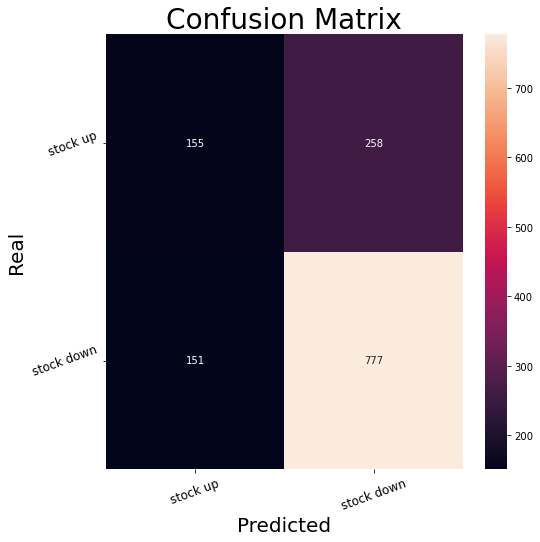

38


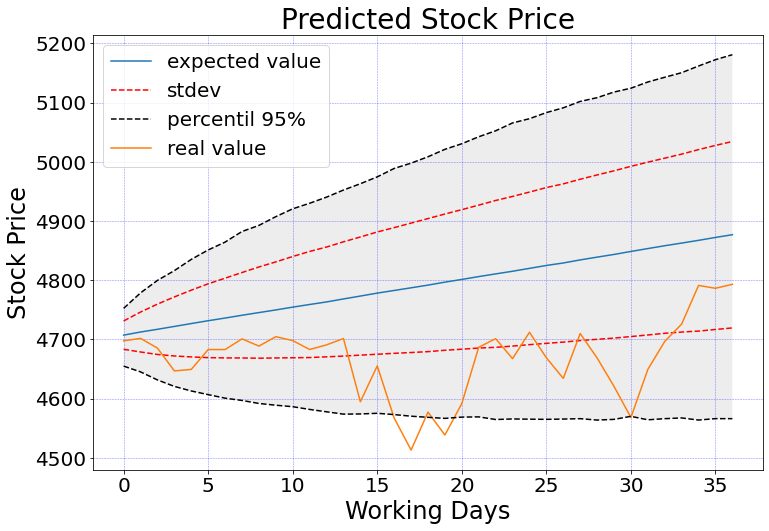

In [50]:
#########################################################
# Control Panel
#########################################################

ticker = '^GSPC'
start = '2010-01-01'
predict_range = 60
MCMC_sample_size = 10000

get_stock_price_prediction(ticker = ticker, 
                           start_date = start, 
                           days_to_evaluate = predict_range, 
                           MCMC_sample_size = MCMC_sample_size)